# **TP 3: Uncertainty Applications**

This last lab session will focus on applications based on uncertainty estimation. We will first use MC Dropout variational inference to qualitatively evaluate the most uncertain images for classification .
Then, we'll apply the uncertainty for an important application: failure prediction.

**Goal**: Take hand on applying uncertainty estimation for classification and use it for failure prediction


## **Preliminary: download MNIST dataset**

**First, we will download the MNIST dataset** (train/test images and labels): [https://thome.isir.upmc.fr/classes/MVA/mnist-data.pcl](https://thome.isir.upmc.fr/classes/MVA/mnist-data.pcl)

**Then, the dataset will be loaded into memory to speed up computations:**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
from matplotlib.pyplot import imread
%matplotlib inline
import _pickle as pickle
from tqdm.notebook import tqdm

from sklearn.metrics import precision_recall_curve, average_precision_score

import torch
import torch.nn as nn
import torch.nn.functional as F

use_cuda = True
device = torch.device("cuda" if use_cuda else "cpu")
kwargs = {'num_workers': 4, 'pin_memory': True} if use_cuda else {}

!wget https://thome.isir.upmc.fr/classes/MVA/mnist-data.pcl
outfile = 'mnist-data.pcl'
[X_train, y_train,X_test, y_test] = pickle.load( open( outfile, "rb" ) )

X_train = X_train.to(device)
y_train = y_train.to(device)
X_test = X_test.to(device)
y_test = y_test.to(device)

--2023-11-30 22:11:33--  https://thome.isir.upmc.fr/classes/MVA/mnist-data.pcl
Resolving thome.isir.upmc.fr (thome.isir.upmc.fr)... 134.157.18.247
Connecting to thome.isir.upmc.fr (thome.isir.upmc.fr)|134.157.18.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 324509627 (309M) [application/octet-stream]
Saving to: ‘mnist-data.pcl’

mnist-data.pcl      100%[===================>] 309.48M  23.9MB/s    in 14s     

2023-11-30 22:11:48 (22.4 MB/s) - ‘mnist-data.pcl’ saved [324509627/324509627]



## **Part I : MC Dropout for classification on MNIST**

**We will design a 'LeNet-like' Convolutional neural network (ConvNet) with the following architecture:**

- A conv layer with 16 5x5 filters, followed by a max pooling a size (2,2)
- A conv layer with 32 5x5 filters, followed by a max pooling a size (2,2). From this stage, flatten the tensor
- A dropout layer with p=0.5
- A fully connected layer with 100 hidden units, and ReLU activation
- A dropout layer with p=0.25
- A fully connected layer with 10 output classes

### **I.1: Training a ConvNet with dropout on MNIST**

In [ ]:
#TO DO: Code a LeNet-style neural network.
class LeNet(nn.Module):
    def __init__(self, n_classes=10):
        super().__init__()
        self.conv1 = nn.Conv2d(1,16,kernel_size = 5)
        self.pool = nn.MaxPool2d(kernel_size = 2)
        self.conv2 = nn.Conv2d(16,32,kernel_size = 5)
        self.fc1 = nn.Linear(16*32,100)
        self.fc2 = nn.Linear(100,10)
        # To do

    def forward(self, x):
        out = self.pool(self.conv1(x))
        out = self.pool(self.conv2(out))
        out = out.view(-1,32*4*4)
        out = F.dropout(out,0.5)
        out = F.relu(self.fc1(out))
        out = F.dropout(out,0.25)
        out = F.relu(self.fc2(out))

        return out

In [ ]:
net = LeNet()
net.to(device)

LeNet(
  (conv1): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=512, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

**Now, fill the code below to train the network for 20 epochs**

In [ ]:
from torch.autograd import Variable

# Assuming 'net' is your neural network model
net.to(device)  # Move the model to GPU if available

tbatch = 100
nb_epochs = 20
nbbatchs = int(X_train.shape[0] / tbatch)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

for epoch in range(nb_epochs):  # loop over the dataset multiple times
    for i in range(nbbatchs):
        X_batch = X_train[i * tbatch: (i + 1) * tbatch, :, :]
        y_batch = y_train[i * tbatch: (i + 1) * tbatch]
        X_batch_var = Variable(X_batch).to(device)  # Move the input data to GPU
        y_batch_var = Variable(y_batch).to(device)  # Move the labels to GPU
        optimizer.zero_grad()
        outputs = net(X_batch_var)
        loss = criterion(outputs, y_batch_var)
        loss.backward()
        optimizer.step()

# Save your model in case the session crashes
torch.save(net.state_dict(), 'lenet_final.cpkt')


In [ ]:
print(outputs.shape)
print(X_batch.shape)

torch.Size([100, 10])
torch.Size([100, 1, 28, 28])


### **I.2: MC sampling on test set**
Once your ConvNet model with dropout is trained, apply MC sampling in the test set to approximate the predictive distribution for each sample

In [ ]:
net.load_state_dict(torch.load('lenet_final.cpkt', map_location=device))


<All keys matched successfully>

In [ ]:
import torch.nn.functional as F

def MC_sampling(X, y, net, tbatch=100, samples=200):
    net.eval()  # Set the model to evaluation mode
    net.to(device)

    outputs = torch.zeros(samples, X.shape[0], 10).to(device)

    X = torch.tensor(X, dtype=torch.float32).to(device)
    y = torch.tensor(y, dtype=torch.long).to(device)

    dataset = torch.utils.data.TensorDataset(X, y)
    dataloader = torch.utils.data.DataLoader(dataset, batch_size=tbatch, shuffle=False)

    with torch.no_grad():
        for i in range(samples):
            for X_batch, _ in dataloader:
                X_batch = X_batch.to(device)
                predictions = net(X_batch)
                outputs[i, :X_batch.size(0)] = predictions

    outputs = F.softmax(outputs, dim=2)
    return outputs

In [ ]:
MC_samples = MC_sampling(X_test, y_test, net)

<ipython-input-7-702837b49ff3>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X = torch.tensor(X, dtype=torch.float32).to(device)
<ipython-input-7-702837b49ff3>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y = torch.tensor(y, dtype=torch.long).to(device)


In [ ]:
print(MC_samples.shape)

torch.Size([200, 10000, 10])


In [ ]:
nS = MC_samples.shape[0]
MC_samples_SM = F.softmax(MC_samples, dim=2) # Apply soft-max
nbtest = X_test.shape[0]
am = torch.argmax(MC_samples, axis=2) # Compute predicted class for each MC sampling and each example
am = am.cpu()
hists = [np.histogram(am[:,i], range=(0,10)) for i in range(nbtest)]

**We will now compute a classification uncertainty metric based on predictive distribution on test images.**

Let us consisder an image $\mathbf{x}$, for which we have a set of $N_S$ samples, each sample corresponding to a vector of size $N_C$ ($N_C$ being the number of classes). We compute an histogram of predictions over the $N_S$ samples: the histogram dispersion provides an indicator of the predictive uncertainty.
Specifically, we use the following "variation-ratio" metric:

$$ variation-ratio[\mathbf{x}] = 1 - \frac{f_x^{c^*}}{T}
$$

where $f_x^{c^*}$ is the number of occurences in histogram corresponding to the majority class, (*i.e.* the mode) ${c^*}$.

We can compute the predictions histograms as follows:

Then the model predictions for each example are computing as the majority class among MC samples:

In [ ]:
pred_vr = [0 for i in range(10000)]
for i in range(10000):
    pred_vr[i] = np.argmax(hists[i][0])

pred_vr2 = torch.tensor(np.array(pred_vr), dtype=torch.long).to(device)

print(pred_vr2[0:10])
print(hists[10:70])

tensor([8, 9, 0, 1, 2, 3, 4, 5, 6, 7], device='cuda:0')
[(array([  0,   0,   0,   0,   0,   0,   0,   0, 200,   0]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])), (array([200,   0,   0,   0,   0,   0,   0,   0,   0,   0]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])), (array([  0, 200,   0,   0,   0,   0,   0,   0,   0,   0]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])), (array([  0,   0, 200,   0,   0,   0,   0,   0,   0,   0]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])), (array([  0,   0,   0, 200,   0,   0,   0,   0,   0,   0]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])), (array([  0,   0,   0,   0, 200,   0,   0,   0,   0,   0]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])), (array([  0,   0,   0,   0,   0,   0,   0, 200,   0,   0]), array([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10.])), (array([  0,   0,   0,   0,   0,   0,   0,   0, 200,   0]), array([ 

**From prediction histograms, compute the "variation-ratio" uncertainty metric:**

In [ ]:
just_hists = [hists[i][0] for i in range(10000)]
fx = np.array([np.max(v) for v in just_hists]) / 200.0  # Assuming 200 samples per class
var_ratio = 1.0 - fx
print(var_ratio[0:20])

[0.    0.    0.    0.    0.09  0.195 0.005 0.    0.    0.    0.    0.
 0.    0.    0.    0.    0.    0.    0.    0.   ]


We can then sort test examples by increasing confidence $f_x$

In [ ]:
var_ratio_tensor = torch.tensor(var_ratio, dtype=torch.float32).to(device)
print(var_ratio_tensor)

var_ratio_sorted, uncertain_samples = torch.sort(var_ratio_tensor, descending=True)
print(var_ratio_sorted)
uncertain_samples = uncertain_samples.to(torch.int32)  # Ensure indices are of integer type

tensor([0., 0., 0.,  ..., 0., 0., 0.], device='cuda:0')
tensor([0.6300, 0.2450, 0.2400,  ..., 0.0000, 0.0000, 0.0000], device='cuda:0')


**The following function can be used to draw 25 images ranked from index m regarding confidence:**

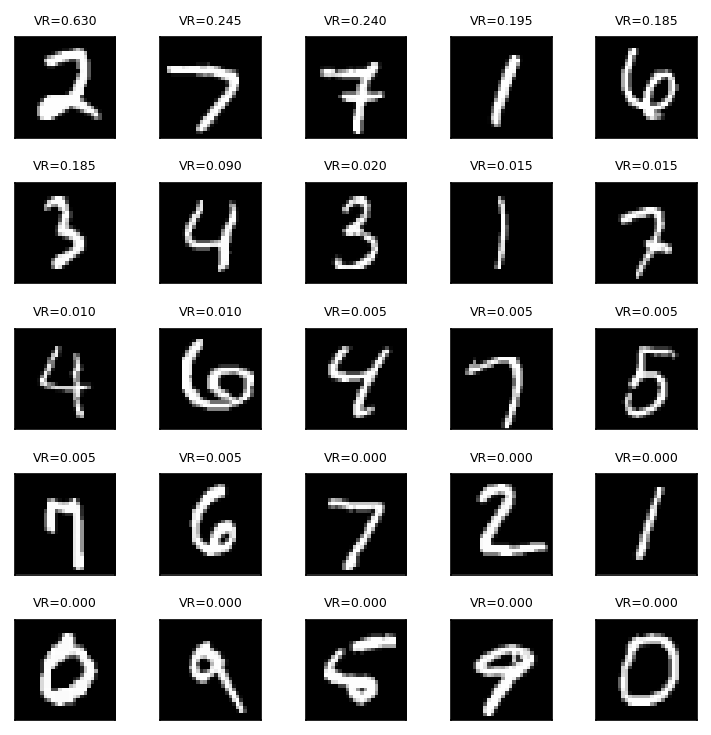

In [ ]:
import matplotlib.pyplot as plt

def showImages(m, var_ratio_sorted, uncertain_samples, X_test):
    # Visualize some images
    fig, axes = plt.subplots(nrows=5, ncols=5, dpi=150)

    for i in range(m, m + 25):
        index = uncertain_samples[i].item()  # Convert to Python int
        variance_ratio = var_ratio_sorted[i].item()  # Access directly

        ax = axes[(i - m) // 5][(i - m) % 5]
        title = f"VR={variance_ratio:.3f}"
        ax.set_title(title, fontsize=6)
        ax.imshow(X_test[index, 0, :, :].cpu(), cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])

    fig.set_size_inches(5, 5)
    fig.tight_layout()

# Usage
showImages(0, var_ratio_sorted, uncertain_samples, X_test)
plt.show()

**Explore image with low and high confidence. Look at images and comment the confidence metric.**

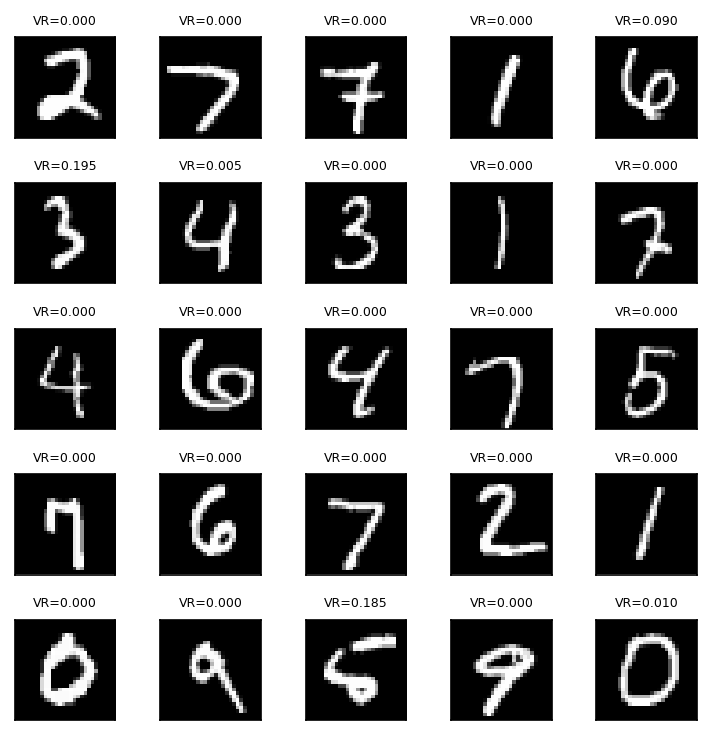

In [ ]:
showImages(0,var_ratio , uncertain_samples, X_test)

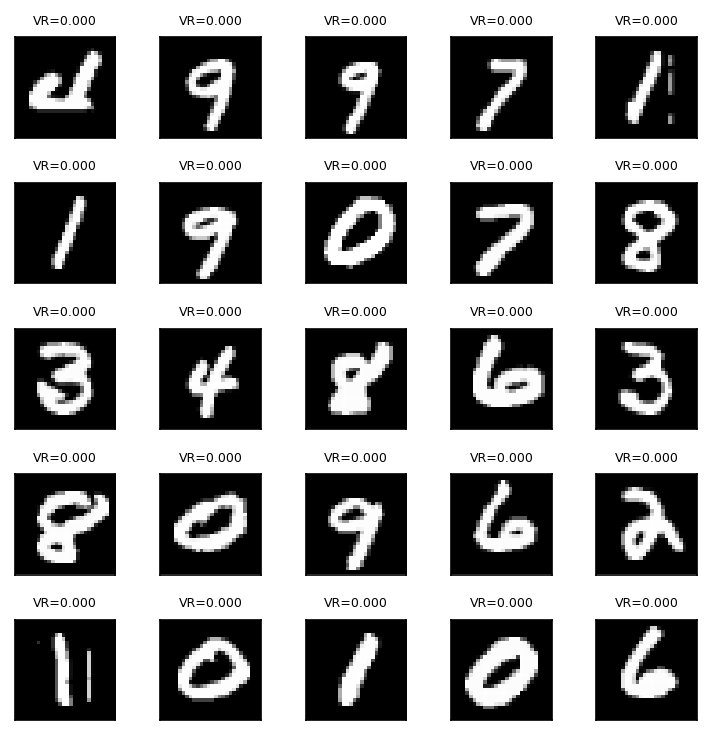

In [ ]:
showImages(8000,var_ratio , uncertain_samples, X_test)

**Finally, the following showUncertainty function can be used to visualize the predictions for a given input image:**
- The mean prediction over MC samples
- The histogram predictions
- The histogram of predictions for the 3 leading classes


In [ ]:
def showUncertainty(MC_sample, hist, img, title):
    size=10

    sSM = F.softmax(MC_sample,dim=1)
    pred_mean = sSM.mean(axis=0)

    fig = plt.figure(dpi=150)
    fig.suptitle(title, fontsize="x-large")
    fig.set_figheight(4)
    fig.set_figwidth(4*5)
    ax = plt.subplot(161)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

    ax = plt.subplot(162)
    ax.bar(range(10),pred_mean)
    ax.set_title("Mean Pred")
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(size)
    ax.set_xticks(range(10))

    ax = plt.subplot(163)
    ax.bar(range(10),hist)
    ax.set_title("Samples Pred")
    ax.set_xticks(range(10))
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(size)

    asorted = np.argsort(pred_mean, axis=0)


    h1 = np.histogram(sSM[:,asorted[9]], range=(0.0,1.0))
    h2 = np.histogram(sSM[:,asorted[8]], range=(0.0,1.0))
    h3 = np.histogram(sSM[:,asorted[7]], range=(0.0,1.0))

    ax =plt.subplot(164)
    ax.bar(range(10),h1[0])
    ax.set_title("Class="+str(asorted[9].numpy()))
    ax.set_yticks(np.arange(0,200,20))
    ax.set_xticks(range(10))
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(size)
    ax = plt.subplot(165)
    ax.bar(range(10),h2[0])
    ax.set_title("Class="+str(asorted[8].numpy()))
    ax.set_yticks(np.arange(0,200,20))
    ax.set_xticks(range(10))
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(size)
    ax = plt.subplot(166)
    ax.bar(range(10),h3[0])
    ax.set_title("Class="+str(asorted[7].numpy()))
    ax.set_yticks(np.arange(0,200,20))
    ax.set_xticks(range(10))
    for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] + ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(size)
    plt.show()


torch.cuda.FloatTensor


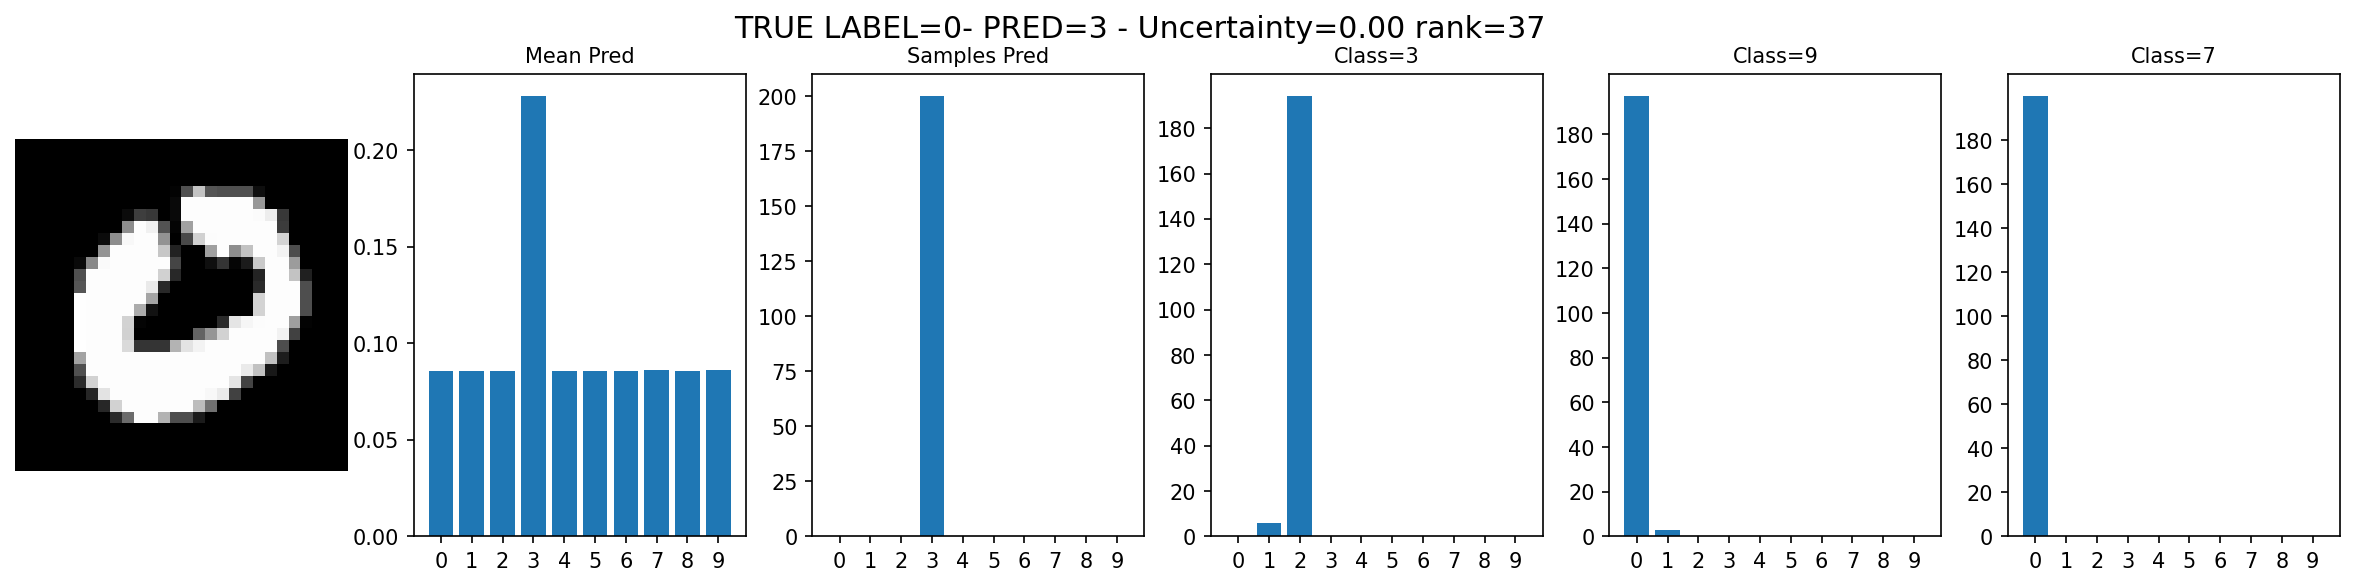

In [ ]:
min =10
max=100

cpt=np.random.randint(min,max)
index = uncertain_samples[cpt]

print(MC_samples.type())
MC_samples = MC_samples.cpu()

title = "TRUE LABEL="+str(y_test[index].cpu().numpy())+"- PRED="+str(pred_vr2[index].cpu().numpy())+ " - Uncertainty="+str("{:0.2f}".format(var_ratio[index]))+" rank="+str(cpt)
showUncertainty(MC_samples[:,index,:], hists[index][0], X_test[index,0,:,:].reshape([28,28]).cpu(), title)


## **Part II : Failure Prediction**

**The objective is to provide confidence measures for model’s predictions that are reliable and whoseranking among samples enables to distinguish correct from incorrect predictions. Equipped with sucha confidence measure, a system could decide to stick to the prediction or, on the contrary, to handover to a human or a back-up system with, *e.g.* other sensors, or simply to trigger an alarm.**

<img src="https://thome.isir.upmc.fr/classes/MVA/failure.png" title="Failure prediction">

**We will introduce ConfidNet, a specific method design to address failure prediction and we will compare it to MCDropout with entropy and Maximum Class Probability (MCP).**

### **II.1 ConfidNet**

By taking the largest softmax probability as confidence estimate, MCP leads to high confidence values both for correct and erroneous predictions alike. On the other hand, when the model misclassifies an example, the probability associated to the true class $y$ is lower than the maximum one and likely to be low.

Based on this observation, we can consider instead the **True Class Probability** as a suitable uncertainty criterion.
For any admissible input $\pmb{x}\in \mathcal{X}$, we assume the *true* class $y(\pmb{x})$ is known, which we denote $y$ for simplicity. The TCP of a model $F$ is defined as  
\begin{equation}
    \text{TCP}_F(\pmb{x},y) = P(Y=y \vert \pmb{x}, \hat{\pmb{w}})
\end{equation}

**Theoretical guarantees.** Given a properly labelled example $(\pmb{x},y)$, then:
- $\text{TCP}_F(\pmb{x},y)> 1/2$ $\Rightarrow$ $f(\pmb{x}) = y$, *i.e.* the example is correctly classified by the model;%the example has been correctly classified,
- $\text{TCP}_F(\pmb{x},y) < 1/K$ $\Rightarrow$ $f(\pmb{x}) \neq y$, *i.e.* the example is wrongly classified by the model.

However, the true classes $y$ are obviously not available when estimating confidence on test inputs. Alternatively, we can **learn TCP criterion from data** with an auxiliary model called **ConfidNet**.

ConfidNet is designed as a small multilayer perceptron composed of a succession of dense layers with a final sigmoid activation that outputs $C(\pmb{x};\pmb{\theta})\in[0,1]$. We use a mean-square-error (MSE) loss to train this model:
\begin{equation}
\mathcal{L}_{\text{conf}}(\pmb{\theta};\mathcal{D}) = \frac{1}{N} \sum_{n=1}^N \big(C(\pmb{x}_n;\pmb{\theta}) - \text{TCP}_F(\pmb{x}_n,y_n)\big)^2.
\end{equation}

<img src="https://thome.isir.upmc.fr/classes/MVA/confidnet.jpg" title="ConfidNet">

In [ ]:
class LeNetConfidNet(nn.Module):
    ''' A LeNet-syle model equipped with ConfidNet auxiliary branch '''
    def __init__(self, n_classes=10):
        super(LeNetConfidNet, self).__init__()
        # 1 input image channel, 6 output channels, 3x3 square convolution
        # kernel
        self.conv1 = nn.Conv2d(1, 16, 5)
        self.conv2 = nn.Conv2d(16, 32, 5)
        # an affine operation: y = Wx + b
        self.fc1 = nn.Linear(16*32, 100)  # 6*6 from image dimension
        self.fc2 = nn.Linear(100, 10)

        # ConfidNet Layers
        self.uncertainty1 = nn.Linear(100, 400)
        self.uncertainty2 = nn.Linear(400, 400)
        self.uncertainty3 = nn.Linear(400, 400)
        self.uncertainty4 = nn.Linear(400, 400)
        self.uncertainty5 = nn.Linear(400, 1)

    def forward(self, x):
       # Max pooling over a (2, 2) window
        out = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        # If the size is a square you can only specify a single number
        out = F.max_pool2d(F.relu(self.conv2(out)), 2)
        out = out.view(-1, self.num_flat_features(out))
        out = F.dropout(out, 0.5, training=self.training)
        out = F.relu(self.fc1(out))
        out = F.dropout(out, 0.25, training=self.training)

        # Uncertainty prediction
        uncertainty = F.relu(self.uncertainty1(out))
        uncertainty = F.relu(self.uncertainty2(uncertainty))
        uncertainty = F.relu(self.uncertainty3(uncertainty))
        uncertainty = F.relu(self.uncertainty4(uncertainty))
        uncertainty = self.uncertainty5(uncertainty)

        pred = self.fc2(out)
        return pred, uncertainty

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

    def count_parameters(model):
        return sum(p.numel() for p in model.parameters() if p.requires_grad)


In [ ]:
class SelfConfidMSELoss(nn.modules.loss._Loss):
    ''' MSE Loss for confidence learning '''
    def __init__(self, num_classes,device):
        self.nb_classes = num_classes
        self.device = device
        super().__init__()

    def forward(self, input, target):
        probs = F.softmax(input[0], dim=1)
        confidence = torch.sigmoid(input[1]).squeeze()
        labels_hot = torch.eye(10)[target.flatten()].to(device)
        loss = (confidence - (probs * labels_hot).sum(dim=1)) ** 2
        return torch.mean(loss)

**We train only the ConfidNet layers for 50 epochs. During confidence learning, original classification layers are fixed to keep predictions unchanged.**

In [ ]:
lenet_confidnet = LeNetConfidNet(n_classes=10).to(device)
lenet_confidnet.load_state_dict(torch.load('lenet_final.cpkt'), strict=False)
lenet_confidnet.train()
optimizer = torch.optim.Adam(lenet_confidnet.parameters(), lr=1e-4)
criterion = SelfConfidMSELoss(10,device)

tbatch =100
nb_epochs=50
nbbatchs = int(X_train.shape[0]/100)

# Freezing every layer except uncertainty for confidence training
for param in lenet_confidnet.named_parameters():
    if "uncertainty" in param[0]:
        continue
    param[1].requires_grad = False

best_aupr = 0.0

for e in range(nb_epochs):
    lenet_confidnet.train()

    total_loss, correct = 0.0, 0.0
    errors, uncertainty = [], []

    for i in range(nbbatchs):
        X_batch = X_train[i*100:(i+1)*100,:,:]
        y_batch = y_train[i*100:(i+1)*100]

        optimizer.zero_grad()

        output = lenet_confidnet(X_batch)
        probs = F.softmax(output[0], dim=1)
        pred = probs.max(dim=1)[1]
        loss = criterion(output, y_batch.cpu())
        loss.backward()
        optimizer.step()
        total_loss += loss
        correct += (pred == y_batch).sum()
        errors.extend((pred != y_batch.view_as(pred)).detach().to("cpu").numpy())
        uncertainty.extend(output[1].squeeze().detach().to("cpu").numpy())

    errors_test, uncertainty_test = [], []
    lenet_confidnet.eval()
    nbbatchstest = int(X_test.shape[0]/tbatch)
    for i in range(nbbatchstest):
        X_batch = X_test[i*100:(i+1)*100,:,:]
        y_batch = y_test[i*100:(i+1)*100]
        with torch.no_grad():
          output = lenet_confidnet(X_batch)
        pred = output[0].max(dim=1)[1]
        errors_test.extend((pred != y_batch.view_as(pred)).detach().to("cpu").numpy())
        uncertainty_test.extend(output[1].squeeze().detach().to("cpu").numpy())

    errors = np.reshape(errors, newshape=(len(errors), -1)).flatten()
    uncertainty = np.reshape(uncertainty, newshape=(len(uncertainty), -1)).flatten()
    aupr = average_precision_score(errors, -uncertainty)
    errors_test = np.reshape(errors_test, newshape=(len(errors_test), -1)).flatten()
    uncertainty_test = np.reshape(uncertainty_test, newshape=(len(uncertainty_test), -1)).flatten()
    print(f"[Epoch {e + 1}] loss: {total_loss/ X_train.shape[0]:.2E}"+
          f"\t accuracy_train: {correct / X_train.shape[0]:.2%}"+
          f"\t aupr_train: {aupr:.2%}"+
          f"\t aupr_test: {average_precision_score(errors_test, -uncertainty_test):.2%}")
    if aupr>best_aupr:
      best_aupr = aupr
      torch.save(lenet_confidnet.state_dict(), 'lenet_confidnet_best.cpkt')

lenet_confidnet.load_state_dict(torch.load('lenet_confidnet_best.cpkt'))

[Epoch 1] loss: 3.32E-04	 accuracy_train: 91.77%	 aupr_train: 27.47%	 aupr_test: 32.59%
[Epoch 2] loss: 1.93E-04	 accuracy_train: 91.87%	 aupr_train: 42.82%	 aupr_test: 43.32%
[Epoch 3] loss: 1.54E-04	 accuracy_train: 91.86%	 aupr_train: 50.10%	 aupr_test: 50.55%
[Epoch 4] loss: 1.29E-04	 accuracy_train: 91.81%	 aupr_train: 56.25%	 aupr_test: 54.29%
[Epoch 5] loss: 1.14E-04	 accuracy_train: 91.80%	 aupr_train: 59.91%	 aupr_test: 59.59%
[Epoch 6] loss: 9.87E-05	 accuracy_train: 91.81%	 aupr_train: 63.11%	 aupr_test: 62.86%
[Epoch 7] loss: 9.24E-05	 accuracy_train: 91.87%	 aupr_train: 64.42%	 aupr_test: 62.71%
[Epoch 8] loss: 8.39E-05	 accuracy_train: 91.84%	 aupr_train: 68.55%	 aupr_test: 64.89%
[Epoch 9] loss: 8.02E-05	 accuracy_train: 91.87%	 aupr_train: 69.54%	 aupr_test: 67.04%
[Epoch 10] loss: 7.65E-05	 accuracy_train: 91.90%	 aupr_train: 68.69%	 aupr_test: 67.80%
[Epoch 11] loss: 7.64E-05	 accuracy_train: 91.68%	 aupr_train: 70.52%	 aupr_test: 68.46%
[Epoch 12] loss: 7.31E-05	 acc

<All keys matched successfully>

In [ ]:
# If you already train your model, you can load it instead using :
#lenet_confidnet.load_state_dict(torch.load('lenet_confidnet_best.cpkt'))

### **II.2 Evaluate failure prediction performances**

**We compare the capacity of ConfidNet to detect failures with previous baselines (MCP and MCDropout with variation-ratio).**

To measure performances, we use the *Area under the Precision-Recall* curve (AUPR). The precision-recall (PR) curve is the graph of the precision $= \mathrm{TP}/(\mathrm{TP} + \mathrm{FP})$ as a function of the recall $= \mathrm{TP}/(\mathrm{TP} + \mathrm{FN})$ where $\mathrm{TP}$, $\mathrm{TN}$, $\mathrm{FP}$ and $\mathrm{FN}$ are the numbers of true positives, true negatives, false positives and false negatives respectively. In our experiments, classification errors are used as the positive detection class.

**We can use the following function for test set prediction:**

In [ ]:
#@title **[CODING TASK]** Implement variational-ratio, entropy and mutual information

def predict_test_set(model, X_test,y_test, mode='mcp', s=100, temp=5, epsilon=0.0006, verbose=True):
    """Predict on a test set given a model
    # and a chosen method to compute uncertainty estimate
    # (mcp, MC-dropout with var-ratios/entropy/mutual information
    # ConfidNet and ODIN)

    Args:
      model: (nn.Module) a trained model
      X_test,y_test: Data & labels
      mode: (str) chosen uncertainty estimate method (mcp, var-ratios, entropy, mi, odin)
      s: (int) number of samples in MCDropout
      temp: (int, optional) value of T for temperature scaling in ODIN
      epsilon: (float, optional) value of epsilon for inverse adversarial perturbation in ODIN
      verbose: (bool, optional) printing progress bar when predicting

    Returns:
      pred: (tensor) class predictions by the model
      labels: (tensor) true labels of the given dataset
      uncertainties: (tensor) uncertainty estimates of the given dataset
      errors: (tensor) 0/1 vector whether the model wrongly predicted a sample
      hists : (array) number of occurences by class in each sample fo the given dataset, only with MCDropout
      mc_samples: (tensor) prediction matrix for s=100 samples, only with MCDropout
    """
    tbatch =100
    nbbatchs = int(X_test.shape[0]/100)

    preds, uncertainties, labels, errors  = [], [], [], []
    mc_samples, hists = [], []
    model.eval()

    #loop = tqdm(test_loader, disable=not verbose)
    for i in range(nbbatchs):
        images = X_test[i*100:(i+1)*100,:,:]
        targets = y_test[i*100:(i+1)*100]

        if mode in ['mcp','odin']:
            model.training = False
            if mode=='odin':
                # Coding task in Section 3: implement ODIN
                images = odin_preprocessing(model,images,epsilon).to(device)
            with torch.no_grad():
                output = model(images)
            if isinstance(output,tuple):
                output = output[0]
            if mode =='odin':
                output = output / temp
            confidence, pred = F.softmax(output, dim=1).max(dim=1, keepdim=True)
            confidence = confidence.detach().to('cpu').numpy()

        elif mode in ['var-ratios', 'entropy', 'mut_inf']:
            model.training = True
            outputs = torch.zeros(images.shape[0], s, 10)
            # Existing code
            for i in range(s):
              with torch.no_grad():
                  model_output = model(images)

              # Unpack the model_output correctly
              if isinstance(model_output, tuple):
                  pred, uncertainty = model_output
              else:
                  pred, uncertainty = model_output, None

              outputs[:, i] = pred
            mc_probs = F.softmax(outputs, dim=2)
            predicted_class = mc_probs.max(dim=2)[1]
            pred = mc_probs.mean(1).max(dim=1, keepdim=True)[1]
            mc_samples.extend(mc_probs)
            hist = np.array([np.histogram(predicted_class[i,:], range=(0,10))[0]
                              for i in range(predicted_class.shape[0])])
            hists.extend(hist)

            # ============ YOUR CODE HERE ============
            if mode=='var-ratios':
                # You may want to use the hist variable here
                confidence = 1. - hist.max(axis=1)/s
            elif mode=='entropy':
                confidence = -(mc_probs.mean(1)*torch.log(mc_probs.mean(1)+1e-9)).sum(dim=1)
            elif mode=='mut_inf':
                confidence = -(mc_probs.mean(1)*torch.log(mc_probs.mean(1)+1e-9)).sum(dim=1) \
                                    + (mc_probs*torch.log(mc_probs+1e-9)).sum(dim=2).mean(dim=1)
            # =======================================

        elif mode=='confidnet':
          with torch.no_grad():
            output, confidence = model(images)
          _, pred = F.softmax(output, dim=1).max(dim=1, keepdim=True)
          confidence = confidence.detach().to('cpu').numpy()

        preds.extend(pred.cpu())
        labels.extend(targets.cpu())
        uncertainties.extend(confidence)
        errors.extend((pred.to(device)!=targets.view_as(pred)).detach().to("cpu").numpy())

    preds = np.reshape(preds, newshape=(len(preds), -1)).flatten()
    labels = np.reshape(labels, newshape=(len(labels), -1)).flatten()
    uncertainties = np.reshape(uncertainties, newshape=(len(uncertainties), -1)).flatten()
    errors = np.reshape(errors, newshape=(len(errors), -1)).flatten()

    if mode in ['var-ratios', 'entropy', 'mi']:
        hists = np.reshape(hists, newshape=(len(hists), -1))

    print(f'Test set accuracy = {(preds == labels).sum()/len(preds):.2%}')

    return preds, labels, uncertainties, errors, hists, mc_samples

In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Use the predict_test_set function with 'confidnet' mode
pred_confidnet, labels_confidnet, uncertainties_confidnet, errors_confidnet, _, _ = predict_test_set(lenet_confidnet, X_test, y_test, mode='confidnet')

# Calculate precision and recall using sklearn functions
precision_confidnet, recall_confidnet, _ = precision_recall_curve(errors_confidnet, -uncertainties_confidnet)

# Calculate AUPR (Area Under the Precision-Recall Curve)
aupr_confidnet = average_precision_score(errors_confidnet, -uncertainties_confidnet)

# Print or use the results as needed
print(f'AUPR for ConfidNet: {aupr_confidnet:.4f}')

# If needed, you can also plot the precision-recall curve
# using matplotlib or other plotting libraries.

Test set accuracy = 96.65%
AUPR for ConfidNet: 0.7168


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Use the predict_test_set function with 'mcp' mode
pred_mcp, labels_mcp, uncertainties_mcp, errors_mcp, _, _ = predict_test_set(lenet_confidnet, X_test, y_test, mode='mcp')

# Calculate precision and recall using sklearn functions
precision_mcp, recall_mcp, _ = precision_recall_curve(errors_mcp, -uncertainties_mcp)

# Calculate AUPR (Area Under the Precision-Recall Curve)
aupr_mcp = average_precision_score(errors_mcp, -uncertainties_mcp)

# Print or use the results as needed
print(f'AUPR for MCP: {aupr_mcp:.4f}')

# If needed, you can also plot the precision-recall curve
# using matplotlib or other plotting libraries.


Test set accuracy = 96.65%
AUPR for MCP: 0.3592


/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


In [ ]:
from sklearn.metrics import precision_recall_curve, average_precision_score

# Use the predict_test_set function with 'mcp' mode
pred_mcd, labels_mcd, uncertainties_mcd, errors_mcd, _, _ = predict_test_set(lenet_confidnet, X_test, y_test, mode='entropy')

# Calculate precision and recall using sklearn functions
precision_mcd, recall_mcd, _ = precision_recall_curve(errors_mcd, uncertainties_mcd)

# Calculate AUPR (Area Under the Precision-Recall Curve)
aupr_mcd = average_precision_score(errors_mcd, uncertainties_mcd)

# Print or use the results as needed
print(f'AUPR for MCP: {aupr_mcd:.4f}')

# If needed, you can also plot the precision-recall curve
# using matplotlib or other plotting libraries.

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


Test set accuracy = 96.70%
AUPR for MCP: 0.2240


**Let**'s look at the comparative results for failure prediction

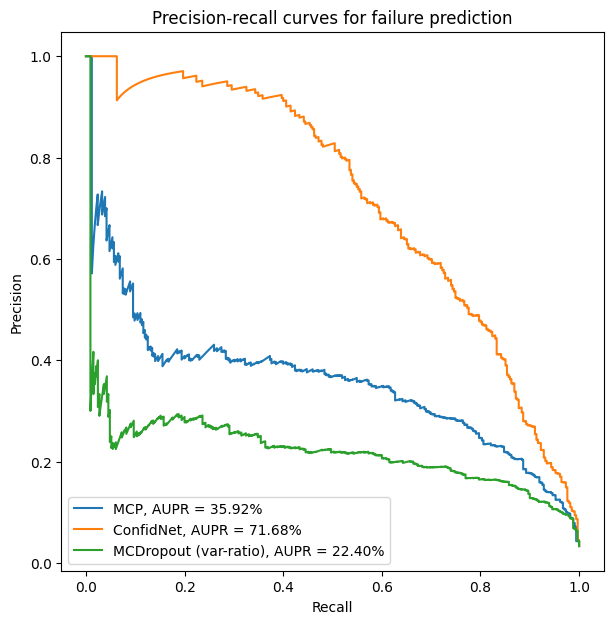

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7, 7))
plt.plot(recall_mcp, precision_mcp, label=f'MCP, AUPR = {aupr_mcp:.2%}')
plt.plot(recall_confidnet, precision_confidnet, label=f'ConfidNet, AUPR = {aupr_confidnet:.2%}')
plt.plot(recall_mcd, precision_mcd, label=f'MCDropout (var-ratio), AUPR = {aupr_mcd:.2%}')
plt.title('Precision-recall curves for failure prediction')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()


## Part III: Out-of-distribution detection

Modern neural networks are known to generalize well when the training and testing data are sampled from the same distribution. However, when deploying neural networks in real-world applications, there is often very little control over the testing data distribution. It is important for classifiers to be aware of uncertainty when shown new kinds of inputs, i.e., out-of- distribution examples. Therefore, being able to accurately detect out-of-distribution examples can be practically important for visual recognition tasks.

<img src="https://thome.isir.upmc.fr/classes/MVA/ood.png" title="OOD detection">

In this section, we will use Kuzushiji-MNIST, a drop-in replacement for the MNIST dataset (28x28 grayscale, 70,000 images) containing 3832 Kanji (japanese) characters, as out-of-distribution sample to our model trained on MNIST. We will compare the methods for uncertainty estimates used previously and ODIN.

100%|██████████| 18165135/18165135 [00:08<00:00, 2239568.58it/s]


Extracting data/KMNIST/raw/train-images-idx3-ubyte.gz to data/KMNIST/raw



100%|██████████| 29497/29497 [00:00<00:00, 339131.90it/s]


Extracting data/KMNIST/raw/train-labels-idx1-ubyte.gz to data/KMNIST/raw



100%|██████████| 3041136/3041136 [00:01<00:00, 1617988.01it/s]


Extracting data/KMNIST/raw/t10k-images-idx3-ubyte.gz to data/KMNIST/raw



100%|██████████| 5120/5120 [00:00<00:00, 8010009.88it/s]

Extracting data/KMNIST/raw/t10k-labels-idx1-ubyte.gz to data/KMNIST/raw



--2023-11-30 22:14:59--  https://thome.isir.upmc.fr/classes/MVA/Kmnist-data-test.pcl
Resolving thome.isir.upmc.fr (thome.isir.upmc.fr)... 134.157.18.247
Connecting to thome.isir.upmc.fr (thome.isir.upmc.fr)|134.157.18.247|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46214172 (44M) [application/octet-stream]
Saving to: ‘Kmnist-data-test.pcl’

Kmnist-data-test.pc 100%[===================>]  44.07M  16.7MB/s    in 2.6s    

2023-11-30 22:15:03 (16.7 MB/s) - ‘Kmnist-data-test.pcl’ saved [46214172/46214172]



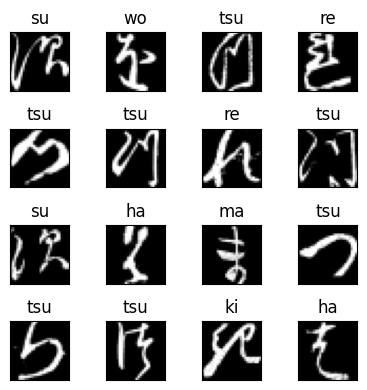

In [ ]:
from torchvision import datasets, transforms

# Load KMNIST dataset
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,),(0.3081,))])
kmnist_test_dataset = datasets.KMNIST('data', train=False, download=True, transform=transform)

!wget https://thome.isir.upmc.fr/classes/MVA/Kmnist-data-test.pcl
outfile = 'Kmnist-data-test.pcl'
[X_testK, y_testK] = pickle.load( open( outfile, "rb" ) )

X_testK = X_testK.to(device)
y_testK = y_testK.to(device)

# Visualize some images
fig, axes = plt.subplots(nrows=4, ncols=4)
for i in range(16):
    if i >= 16:
        break
    axes[i // 4][i % 4].imshow(X_testK.cpu()[i][0], cmap='gray')
    axes[i // 4][i % 4].set_title(f"{kmnist_test_dataset.classes[y_testK[i]]}")
    axes[i // 4][i % 4].set_xticks([])
    axes[i // 4][i % 4].set_yticks([])
fig.set_size_inches(4, 4)
fig.tight_layout()

**We compute the precision, recall and AUPR metric for OOD detection with MCP and MCDropout with var-ratios**

In [ ]:
# Compute predictions for MCP method on MNIST
_, _, uncertainty_mcp, errors_mcp, _, _ = predict_test_set(net, X_test,y_test, mode='mcp')

# Same on KMNIST
_, _, uncertainty_kmnist, errors_kmnist, _, _ = predict_test_set(net, X_testK,y_testK, mode='mcp')

# Concatenating predictions with MNIST, considering KMNIST samples as out-of-distributions
tot_uncertainty = np.concatenate((uncertainty_mcp, uncertainty_kmnist))
in_distribution = np.concatenate((np.zeros_like(uncertainty_mcp), np.ones_like(uncertainty_kmnist)))

# Obtaining precision and recall plot vector + AUPR
precision_ood_mcp, recall_ood_mcp, _ = precision_recall_curve(in_distribution, -tot_uncertainty)
aupr_ood_mcp = average_precision_score(in_distribution, -tot_uncertainty)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


Test set accuracy = 97.99%
Test set accuracy = 8.97%


In [ ]:
# Computing for MCDropout with var-ratios
_, _, uncertainty_mc_dropout, _, _, _ = predict_test_set(net, X_test,y_test, mode='var-ratios')
_, _, uncertainty_mc_dropout_kmnist, _, _, _ = predict_test_set(net, X_testK,y_testK, mode='var-ratios')
tot_uncertainty = np.concatenate((uncertainty_mc_dropout, uncertainty_mc_dropout_kmnist))
in_distribution = np.concatenate((np.zeros_like(uncertainty_mc_dropout), np.ones_like(uncertainty_mc_dropout)))

precision_ood_mc_dropout, recall_ood_mc_dropout, _ = precision_recall_curve(in_distribution, tot_uncertainty)
aupr_ood_mc_dropout = average_precision_score(in_distribution, tot_uncertainty)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


Test set accuracy = 99.06%
Test set accuracy = 9.23%


We will now implement the ODIN method.

ODIN [[Liang et al., ICLR 2018](https://openreview.net/pdf?id=H1VGkIxRZ)], is a threshold-based detector enhancing maximum softmax probabilities with two extensions:
- **temperature scaling**:
	$ \textit{p}(y= c \vert \mathbf{x}, \mathbf{w}, T) = \frac{\exp(f_c( \mathbf{x}, \mathbf{w}) / T)}{\sum_{k=1}^K \exp(f_k( \mathbf{x}, \mathbf{w}) / T)} $
where $T \in \mathbb{R}^{+}$
- **inverse adversarial perturbation**: $ \tilde{\mathbf{x}} = \mathbf{x} - \epsilon \mathrm{sign} \big ( - \nabla_x \log (\textit{p}(y = \hat{y} \vert \mathbf{x}, \mathbf{w}, T) \big ) $

Both technics aimed to increase in-distribution MCP higher than out-distribution MCP. Here, we set the hyperparameters $T=5$ and $\epsilon=0.0014$.

In [ ]:
def odin_preprocessing(model, input, epsilon):
    # Ensure the input requires gradients
    input.requires_grad = True

    # Forward pass through the model
    output = model(input)

    # Get the index of the maximum log-probability
    _, pred = output.max(1)

    # Calculate the loss w.r.t. to class predictions
    loss = F.nll_loss(output, pred)

    # Zero all existing gradients
    model.zero_grad()

    # Calculate gradients of the model in backward pass
    loss.backward()

    # Collect the sign of the data gradient
    sign_input_grad = input.grad.data.sign()

    # Normalize the gradient to the same space as the image
    sign_input_grad /= 0.3081

    # Apply FGSM Attack
    perturbed_input = input + epsilon * sign_input_grad

    return perturbed_input

In [ ]:
# Compute predictions for ODIN on MNIST
_, _, uncertainty_odin, errors_odin, _, _ = predict_test_set(net, X_test,y_test, mode='odin', temp=5, epsilon=0.0014)

# Compute predictions for ODIN on KMNIST
_, _, uncertainty_kmnist, errors_kmnist, _, _ = predict_test_set(net, X_testK,y_testK, mode='odin', temp=5, epsilon=0.0014)

# Concatenating predictions with MNIST, considering KMNIST samples as out-of-distributions
tot_uncertainty = np.concatenate((uncertainty_odin, uncertainty_kmnist))
in_distribution = np.concatenate((np.zeros_like(uncertainty_odin), np.ones_like(uncertainty_kmnist)))

# Obtaining precision and recall plot vector + AUPR
precision_ood_odin, recall_ood_odin, _ = precision_recall_curve(in_distribution, -tot_uncertainty)
aupr_ood_odin = average_precision_score(in_distribution, -tot_uncertainty)

/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  result = getattr(asarray(obj), method)(*args, **kwds)
/usr/local/lib/python3.10/dist-packages/numpy/core/fromnumeric.py:43: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = getattr(asarray(obj), method)(*args, **kwds)


Test set accuracy = 98.25%
Test set accuracy = 8.90%


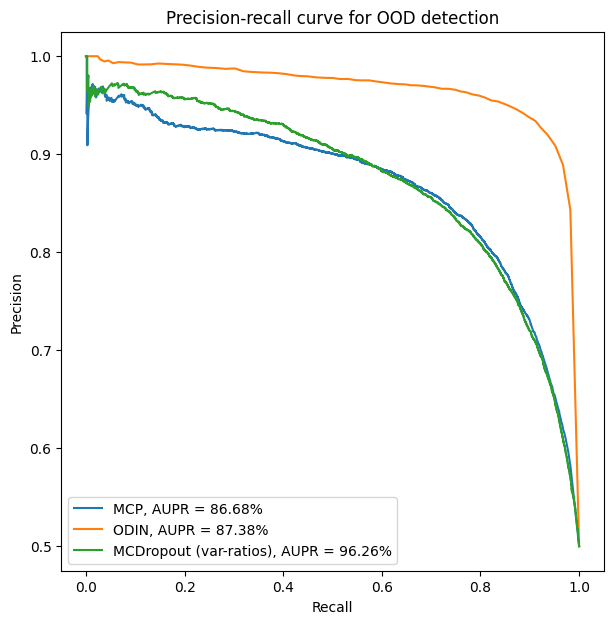

In [ ]:
plt.figure(figsize=(7,7))
plt.title('Precision-recall curve for OOD detection')
plt.plot(recall_ood_mcp, precision_ood_mcp, label = f'MCP, AUPR = {aupr_ood_mcp:.2%}')label = f'ODIN, AUPR = {aupr_ood_odin:.2%}'
plt.plot(recall_ood_mc_dropout, precision_ood_mc_dropout, label = f'MCDropout (var-ratios), AUPR = {aupr_ood_mc_dropout:.2%}')
plt.plot(recall_ood_odin, precision_ood_odin, label = f'ODIN, AUPR = {aupr_ood_odin:.2%}')
plt.legend()
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

**[Question 3.1]: Compare the precision-recall curves of each OOD method along with their AUPR values. Which method perform best and why?**